In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

2025-08-26 18:14:29.182636: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-26 18:14:29.231976: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-26 18:14:30.147480: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
EPOCHS = 20
BATCH_SIZE = 64
VERBOSE = 1
CLASSES = 2
N_HIDDEN = 128
IMAGE_SIZE = 300
LR = 0.0001

In [3]:
train_dir = Path("Dataset/train")
val_dir   = Path("Dataset/val")
test_dir  = Path("Dataset/test")

In [4]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True)
training_set = train_datagen.flow_from_directory(train_dir, 
                                                target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                batch_size = BATCH_SIZE,
                                                color_mode="grayscale",
                                                class_mode = 'binary')

Found 5216 images belonging to 2 classes.


In [5]:
val_datagen = ImageDataGenerator(rescale = 1./255) 

validation_set = val_datagen.flow_from_directory(val_dir,
                                                target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                batch_size = BATCH_SIZE,
                                                color_mode="grayscale",
                                                class_mode = 'binary')

Found 16 images belonging to 2 classes.


In [6]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                           target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                           batch_size = BATCH_SIZE,
                                           class_mode = 'binary',
                                           color_mode="grayscale",
                                           shuffle = False)

Found 624 images belonging to 2 classes.


In [7]:
cnn = tf.keras.models.Sequential()

cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[IMAGE_SIZE, IMAGE_SIZE, 1]))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=4, strides=2))

cnn.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=4, strides=2))

cnn.add(tf.keras.layers.Flatten())

cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))
cnn.add(tf.keras.layers.Dropout(0.5))

cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

optimizer = tf.keras.optimizers.Adam(learning_rate=LR)  

cnn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

/home/diego/uni/magistrale/DL/DL-exam/Chest-X-Ray-Images-Pneumonia-DL-exam/dl_venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1756224871.366219   82471 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9556 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:01:00.0, compute capability: 8.9


In [8]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    'balanced',
    classes = np.unique(training_set.classes),
    y=training_set.classes
)

class_weights = dict(enumerate(class_weights))

model_eval = cnn.fit(training_set, validation_data=validation_set, epochs=EPOCHS, class_weight=class_weights)
# Salva il modello completo in formato .h5
cnn.save("Models/cnn.h5")


/home/diego/uni/magistrale/DL/DL-exam/Chest-X-Ray-Images-Pneumonia-DL-exam/dl_venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


2025-08-26 18:14:34.175361: I external/local_xla/xla/service/service.cc:163] XLA service 0x724ccc014d30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-26 18:14:34.175394: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2025-08-26 18:14:34.196175: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-26 18:14:34.346509: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91200
2025-08-26 18:14:34.908619: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_853', 880 bytes spill stores, 880 bytes spill loads



 2/82 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - accuracy: 0.3398 - loss: 0.7950 

I0000 00:00:1756224881.266022   82601 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


82/82 ━━━━━━━━━━━━━━━━━━━━ 33s 300ms/step - accuracy: 0.7362 - loss: 0.5104 - val_accuracy: 0.6875 - val_loss: 0.6195
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 260ms/step - accuracy: 0.8846 - loss: 0.2836 - val_accuracy: 0.8750 - val_loss: 0.3115
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 253ms/step - accuracy: 0.9028 - loss: 0.2471 - val_accuracy: 0.9375 - val_loss: 0.2378
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 23s 283ms/step - accuracy: 0.9089 - loss: 0.2349 - val_accuracy: 0.9375 - val_loss: 0.2984
Epoch 5/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 256ms/step - accuracy: 0.9187 - loss: 0.2115 - val_accuracy: 0.9375 - val_loss: 0.2030
Epoch 6/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 251ms/step - accuracy: 0.9193 - loss: 0.2060 - val_accuracy: 0.9375 - val_loss: 0.2550
Epoch 7/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 251ms/step - accuracy: 0.9181 - loss: 0.2001 - val_accuracy: 0.9375 - val_loss: 0.3444
Epoch 8/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 23s 280ms/step - accuracy: 0.9306 - loss: 0.1880 - val_accuracy: 0.937

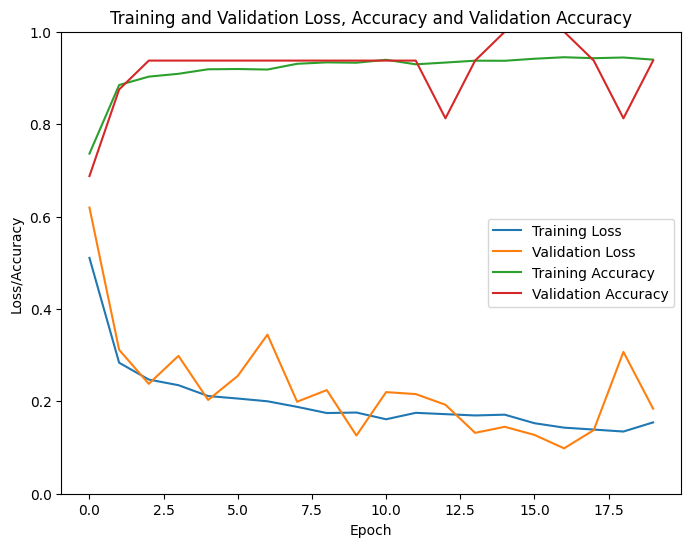

In [12]:
# Plot training and validation loss values
plt.figure(figsize=(8,6))
plt.plot(model_eval.history['loss'], label='Training Loss')
plt.plot(model_eval.history['val_loss'], label='Validation Loss')

plt.plot(model_eval.history['accuracy'], label='Training Accuracy')
plt.plot(model_eval.history['val_accuracy'], label='Validation Accuracy')

plt.title('Training and Validation Loss, Accuracy and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [10]:
# Get class label mapping from the generator
class_labels = {v: k for k, v in test_set.class_indices.items()}

# Make predictions on the whole batch
predictions = cnn.predict(test_set)
pred_class = (predictions > 0.5).astype("int32") # threshold 0.5

# Display predictions (you can map indices to your actual class labels)
for i, prediction in enumerate(pred_class):
    label = class_labels[prediction[0]]
    print(f'Image {test_set.filenames[i]}: {label}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 259ms/step
Image NORMAL/IM-0001-0001.jpeg: NORMAL
Image NORMAL/IM-0003-0001.jpeg: NORMAL
Image NORMAL/IM-0005-0001.jpeg: NORMAL
Image NORMAL/IM-0006-0001.jpeg: NORMAL
Image NORMAL/IM-0007-0001.jpeg: NORMAL
Image NORMAL/IM-0009-0001.jpeg: NORMAL
Image NORMAL/IM-0010-0001.jpeg: NORMAL
Image NORMAL/IM-0011-0001-0001.jpeg: NORMAL
Image NORMAL/IM-0011-0001-0002.jpeg: NORMAL
Image NORMAL/IM-0011-0001.jpeg: NORMAL
Image NORMAL/IM-0013-0001.jpeg: NORMAL
Image NORMAL/IM-0015-0001.jpeg: NORMAL
Image NORMAL/IM-0016-0001.jpeg: NORMAL
Image NORMAL/IM-0017-0001.jpeg: NORMAL
Image NORMAL/IM-0019-0001.jpeg: NORMAL
Image NORMAL/IM-0021-0001.jpeg: NORMAL
Image NORMAL/IM-0022-0001.jpeg: PNEUMONIA
Image NORMAL/IM-0023-0001.jpeg: NORMAL
Image NORMAL/IM-0025-0001.jpeg: NORMAL
Image NORMAL/IM-0027-0001.jpeg: NORMAL
Image NORMAL/IM-0028-0001.jpeg: NORMAL
Image NORMAL/IM-0029-0001.jpeg: NORMAL
Image NORMAL/IM-0030-0001.jpeg: NORMAL
Image NORMAL/IM-0031-0001.jpeg: NORMAL
Image NORM